## Human Activity Recognition

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/gdrive/My Drive/Colab Notebooks/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/gdrive/My Drive/Colab Notebooks/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [49]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(50, input_shape=(timesteps, input_dim), return_sequences=True))

model.add(Dropout(0.6))

#model.add(LSTM(24, return_sequences=True))
# Adding a dropout layer
#model.add(Dropout(0.6))

#model.add(LSTM(24))
# Adding a dropout layer
model.add(LSTM(50))

model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))

model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128, 50)           12000     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 50)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 306       
Total params: 35,056
Trainable params: 35,056
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=30)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.9071 - acc: 0.6130 - val_loss: 0.6927 - val_acc: 0.6946
Epoch 2/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.4859 - acc: 0.7926 - val_loss: 0.5751 - val_acc: 0.7957
Epoch 3/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.3356 - acc: 0.8896 - val_loss: 0.3452 - val_acc: 0.8775
Epoch 4/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.2871 - acc: 0.8989 - val_loss: 0.3946 - val_acc: 0.8636
Epoch 5/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.1822 - acc: 0.9365 - val_loss: 0.4466 - val_acc: 0.8636
Epoch 6/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.2011 - acc: 0.9294 - val_loss: 0.3249 - val_acc: 0.8901
Epoch 7/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.1716 - acc: 0.9344 - val_loss: 0.2948 - val_acc: 0.8873
Epoch 

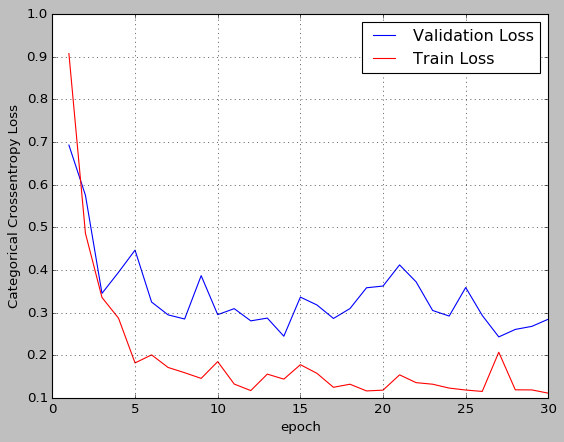

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
plt.style.use('classic')
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [51]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 520        0         0        0                   0   
SITTING                  4      404        81        0                   0   
STANDING                 0      100       430        1                   0   
WALKING                  0        0         0      464                  27   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        0         0        0                  13   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            17  
SITTING                            2  
STANDING                           1  
WALKING                            5  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 458  


In [52]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 961us/step


In [53]:
score

[0.28479463859741877, 0.9148286392941974]

- I got a accuracy of 0.9148 and a loss of 0.284 on Test data
- although at epoch 27 I got a accuracy of 0.9203 and a loss of 0.243